In [5]:
!pip install emoji

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.neighbors import NearestNeighbors
from networkx.algorithms.core import k_core
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
# Load data
with open("Clasico.txt", "r") as file:
    data = file.readlines()

In [9]:
# Parse the data
tweets = []
for line in data:
    parts = line.split("$|")
    if len(parts) == 4:  # Ensure valid format
        TweetID, Tweet_Text, DateTime, Location = parts

        # Process Location
        location_cleaned = Location.strip()
        if len(location_cleaned) == 5:
            location_cleaned = 'none'
        else:
            indices_to_remove = [0, 1, len(location_cleaned)-1, len(location_cleaned)-2, len(location_cleaned)-3]
            location_cleaned = ''.join(
                char for i, char in enumerate(location_cleaned) if i not in indices_to_remove
            )

        tweets.append([TweetID.strip(), Tweet_Text.strip(), DateTime.strip(), location_cleaned])


In [10]:
df = pd.DataFrame(tweets, columns=["TweetID", "Tweet_Text", "DateTime", "Location"])

In [11]:
df.head(10)

,TweetID,Tweet_Text,DateTime,Location
0,0,Barcelona now have the same number of wins as ...,2019-02-27 23:59:57,none
1,1,El Clasico Record 241 Games 95 RealMadrid Wins...,2019-02-27 23:59:56,Rio de janeiro
2,2,Ousmane Dembele El Clasico stats Games 2 Goals...,2019-02-27 23:59:44,camp-nou
3,3,Mandatory Clasico stat Sergio Ramos extends hi...,2019-02-27 23:59:42,Germany - \xf0\x9f\x87\xac\xf0\x9f\x87\xad
4,4,That s how you take a pen in a Cl sico My word,2019-02-27 23:59:39,none
5,5,Glad we won the El Clasico but I can t help bu...,2019-02-27 23:59:35,"London, England"
6,6,It s all equal in the history of El Cl sico Bu...,2019-02-27 23:59:31,"Michigan, USA"
7,7,Barcelona are currently on their best ever unb...,2019-02-27 23:59:18,none
8,8,Ousmane Dembele has more assists in El Clasico...,2019-02-27 23:59:15,Cienfuegos|Burgersfort|Jane F
9,9,Redondizou Hasn t that been the reason we ve l...,2019-02-27 23:59:01,Ireland


In [12]:
# Dictionary for slang and abbreviation mapping
slang_dict = {
    "u": "you",
    "ur": "your",
    "r": "are",
    "idk": "i do not know",
    "brb": "be right back",
    "lmk": "let me know",
    "tbh": "to be honest",
    "omg": "oh my god",
    "lol": "laugh out loud",
    "btw": "by the way",
    "w": "win",
    "l": "loss",
    "tfw": "that feeling when",
    "thx": "thanks",
    "iykyk": "if you know you know",
    "sus": "suspicious",
    "g.o.a.t.": "greatest of all time",
    "f2f": "face to face",
    "b4": "before",
    "ftw": "for the win",
    "ftl": "for the loss",
    "icymi": "in case you missed it",
    "imo": "in my opinion",
    "irl": "in real life",
    "imo": "in my opinion",
    "lmao": "laugh my ass off",
    "lmfao": "laugh my fucking ass off",
    "kk": "okay",
    "tft": "thanks for the follow",
    "wtv": "whatever",
    "ykyat": "You know you are addicted to",
    "yolo": "you only live once",
    "yoyo": "you are on your own",
    "woz": "was",
    "abt": "about",
    "bgd": "background",
    "br": "best regards",
    "bfn": "bye for now",
    "w8": "wait",
    "cmon": "come on",
    "cu": "see you",
    "cya": "see you",
    "cyo": "see you online",
    "cre8": "create",
    "da": "the",
    "dm": "direct message",
    "dno": "don't know",
    "eod": "end of discussion",
    "f2p": "free to play"
}

def expand_slang(text, slang_dict):
    words = text.split()
    expanded_words = [slang_dict[word] if word in slang_dict else word for word in words]
    return ' '.join(expanded_words)

In [13]:
# Dictionary for emoticons to textual meanings
emoticon_dict = {
    ":)": "smile",
    ":-)": "smile",
    ":(": "sad",
    ":-(": "sad",
    ":D": "laugh",
    ":-D": "laugh",
    ":P": "playful",
    ";)": "wink",
    ":-P": "playful",
    ";-)": "wink",
    ":/": "unsure",
    ":-/": "unsure",
}

def replace_emoticons(text, emoticon_dict):
    for emoticon, meaning in emoticon_dict.items():
        text = text.replace(emoticon, meaning)
    return text

In [14]:
def preprocess_data(df):
    # Step 1: Convert text to lowercase
    df['Tweet_Text'] = df['Tweet_Text'].str.lower()

    # Step 2: Remove URLs
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))

    # Step 3: Remove mentions and hashtags
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: re.sub(r'@\w+|#\w+', '', x))

    # Step 4: Handle slang and abbreviations (expand slang, assumed to have `expand_slang` function and `slang_dict`)
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: expand_slang(x, slang_dict))

    # Step 5: Replace emoticons with textual meanings (assumed to have `replace_emoticons` and `emoticon_dict`)
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: replace_emoticons(x, emoticon_dict))

    # Step 6: Convert emojis to their textual meaning
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: emoji.demojize(x))

    # Step 7: Remove punctuations, symbols, and special characters
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: re.sub(r'[^A-Za-z0-9\s:_]', '', x))

    # Step 8: Specify exact format
    df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

    # Extracting time-based features
    df['Hour'] = df['DateTime'].dt.hour
    df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
    df['Month'] = df['DateTime'].dt.month
    df['TimeDiff'] = (df['DateTime'] - df['DateTime'].min()).dt.total_seconds()

    # Step 9: Tokenize, remove stop words, and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    df['Tweet_Text'] = df['Tweet_Text'].apply(lambda x: ' '.join(
        lemmatizer.lemmatize(word) for word in x.split() if word not in stop_words))

    # Step 10: Remove unnecessary columns
    df = df.drop(columns=['TweetID'], axis=1)

    return df

In [15]:
df = preprocess_data(df)

In [16]:
df.head()

,Tweet_Text,DateTime,Location,Hour,DayOfWeek,Month,TimeDiff
0,barcelona number win real madrid el cl sico hi...,2019-02-27 23:59:57,none,23,2,2,11034.0
1,el clasico record 241 game 95 realmadrid win 9...,2019-02-27 23:59:56,Rio de janeiro,23,2,2,11033.0
2,ousmane dembele el clasico stats game 2 goal 0...,2019-02-27 23:59:44,camp-nou,23,2,2,11021.0
3,mandatory clasico stat sergio ramos extends un...,2019-02-27 23:59:42,Germany - \xf0\x9f\x87\xac\xf0\x9f\x87\xad,23,2,2,11019.0
4,take pen cl sico word,2019-02-27 23:59:39,none,23,2,2,11016.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Tweet_Text  1530 non-null   object        
 1   DateTime    1530 non-null   datetime64[ns]
 2   Location    1530 non-null   object        
 3   Hour        1530 non-null   int32         
 4   DayOfWeek   1530 non-null   int32         
 5   Month       1530 non-null   int32         
 6   TimeDiff    1530 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int32(3), object(2)
memory usage: 65.9+ KB


In [18]:
df[df['Location'] == 'none'].shape[0]

428

In [19]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)  # Limit the number of features

# Compute TF-IDF matrix (sparse format)
tfidf_matrix = vectorizer.fit_transform(df["Tweet_Text"])



# Use Nearest Neighbors for approximate similarity (text similarity)
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(tfidf_matrix)

# Find the nearest neighbors for each tweet (based on cosine distance)
distances, indices = nbrs.kneighbors(tfidf_matrix)

# Convert DateTime to datetime format (assuming the 'DateTime' column is a string)
df["DateTime"] = pd.to_datetime(df["DateTime"])

# Compute time similarity (inverse of time difference in seconds)
time_diffs = np.array([[abs((df.iloc[i]["DateTime"] - df.iloc[j]["DateTime"]).total_seconds())
                        for j in range(len(df))] for i in range(len(df))])

# Normalize the time similarity (smaller differences = higher similarity)
time_similarity = 1 / (1 + time_diffs)  # Use 1 / (1 + time_diff) to ensure higher values for smaller time differences

# Combine text and time similarity
# Use a weighted sum of text similarity (from Nearest Neighbors) and time similarity
graph = nx.Graph()

for i in range(len(df)):
    for j in range(len(indices[i])):
        if distances[i, j] < 0.5:  # Define threshold for adding edges based on text similarity
            # Combine text similarity and time similarity
            weight = (1 - distances[i, j]) * 0.7 + time_similarity[i, indices[i, j]] * 0.3
            graph.add_edge(i, indices[i, j], weight=weight)

In [20]:
# Remove self-loops from the graph
graph.remove_edges_from(nx.selfloop_edges(graph))

modularity_score = 0

while True:
    # Apply k-core clustering
    k_core_graph = nx.k_core(graph, k=5)

    # Remove nodes with fewer than 3 common neighbors
    nodes_to_remove = [node for node, degree in k_core_graph.degree() if degree < 3]
    if not nodes_to_remove:  # Stop if no nodes need to be removed
        k_core_clusters = list(nx.connected_components(k_core_graph))
        modularity_score = nx.algorithms.community.quality.modularity(k_core_graph, k_core_clusters)
        break
    k_core_graph.remove_nodes_from(nodes_to_remove)

# Extract clusters
k_core_clusters = list(nx.connected_components(k_core_graph))

<ipython-input-21-596ec55728d2>:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw(k_core_graph, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.get_cmap('tab20', len(k_core_clusters)), node_size=50, font_size=10)


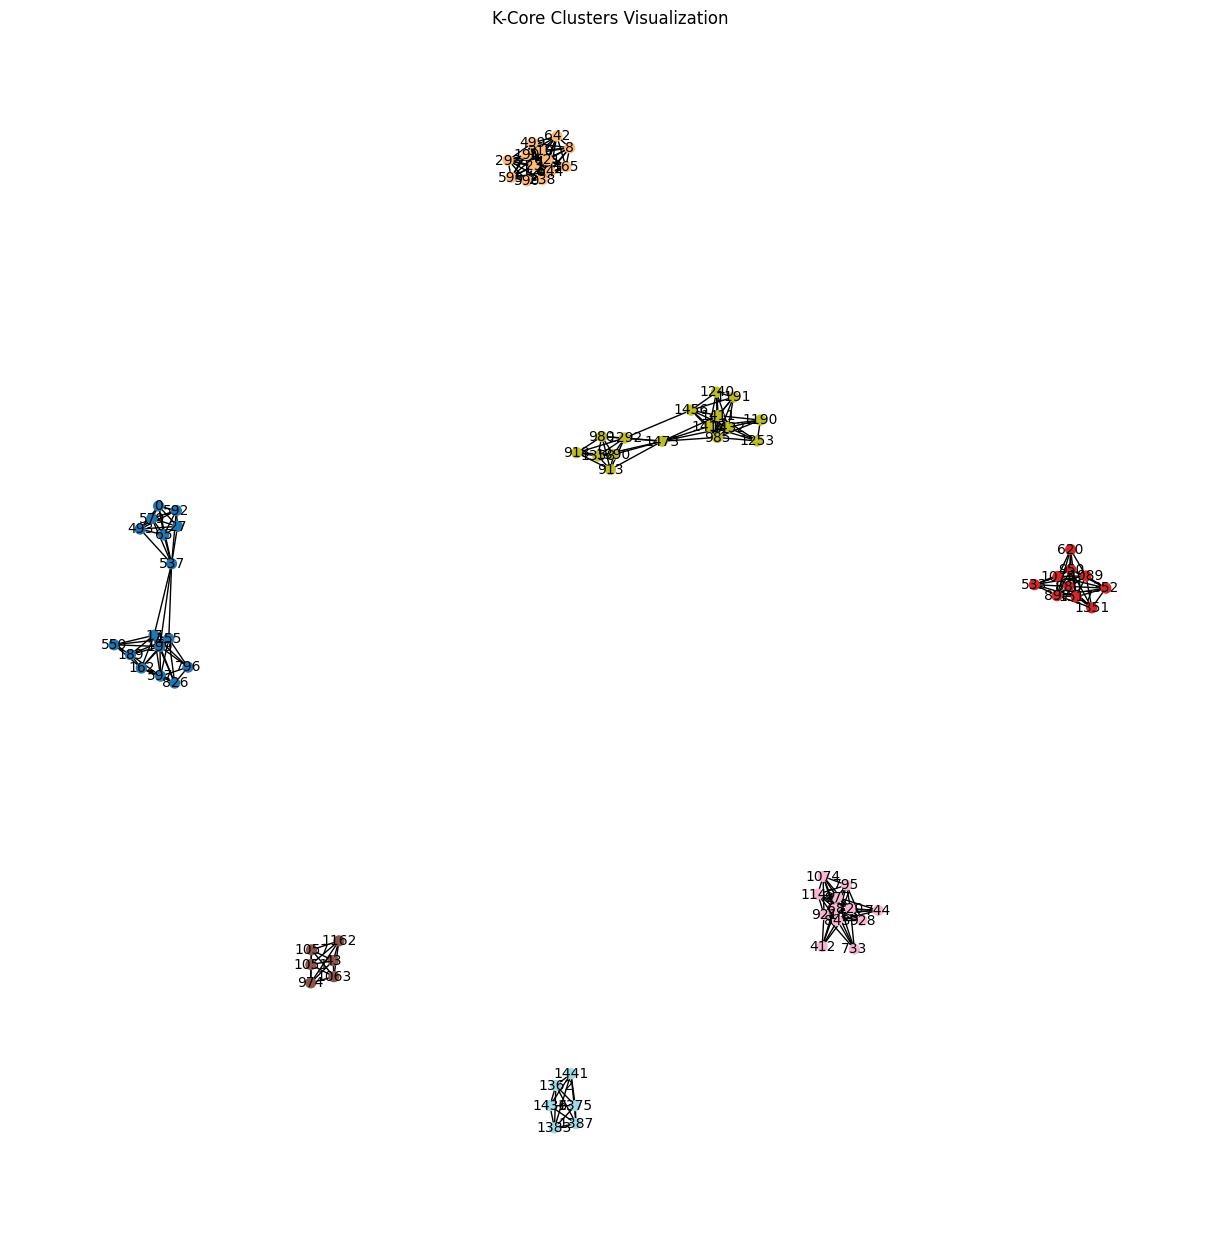

In [21]:
# Assign a unique color to each cluster
color_map = {}
for idx, cluster in enumerate(k_core_clusters):
    for node in cluster:
        color_map[node] = idx  # Map nodes to their cluster

# Plot the graph
plt.figure(figsize=(12, 12))

# Use spring layout to position nodes
pos = nx.spring_layout(k_core_graph, seed=42)

# Draw the graph
node_colors = [color_map[node] for node in k_core_graph.nodes()]
nx.draw(k_core_graph, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.get_cmap('tab20', len(k_core_clusters)), node_size=50, font_size=10)

# Show the plot
plt.title("K-Core Clusters Visualization")
plt.show()

In [22]:
# Initialize a label array with -1 (unclustered nodes or noise)
labels = np.full(len(df), -1)  # Assume -1 for nodes not in any cluster

# Assign cluster labels based on the k-core graph clusters
for cluster_id, cluster in enumerate(k_core_clusters):
    for node in cluster:
        labels[node] = cluster_id

# Check if there are enough clusters for a valid Silhouette Score
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise (-1)

valid_indices = labels != -1
sil_score_kcore = silhouette_score(tfidf_matrix[valid_indices], labels[valid_indices])

In [23]:
# Extract time features
X_time = df[['Hour', 'DayOfWeek', 'Month', 'TimeDiff']].values

# Combine text features and time features
X_combined = hstack([tfidf_matrix, X_time])

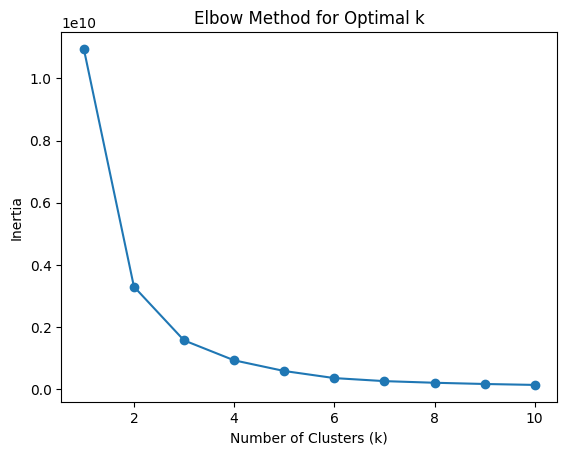

In [24]:
# Range of clusters to try
k_range = range(1, 11)  # You can adjust the range based on your data
inertia = []

# Perform KMeans for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_combined)
    inertia.append(kmeans.inertia_)

# Plotting the elbow graph
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


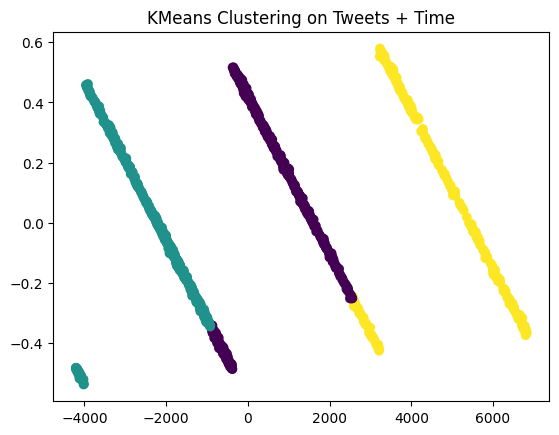

In [25]:
# Set the number of clusters (you can adjust this based on the elbow method or other criteria)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_combined)

# Assigning cluster labels to the DataFrame
df['KMeans_Cluster'] = kmeans.labels_

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined.toarray())

# Plot KMeans clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='viridis')
plt.title('KMeans Clustering on Tweets + Time')
plt.show()

sil_score_kmeans = silhouette_score(X_combined, df['KMeans_Cluster'])

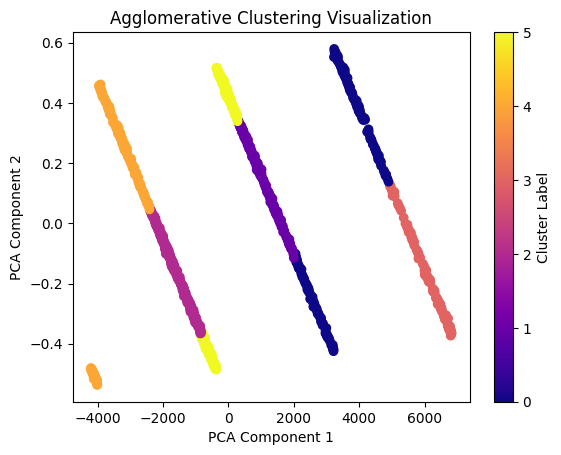

In [26]:
# Convert sparse matrix to dense array
X_dense = X_combined.toarray()

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=6)  # Adjust the number of clusters as needed
agg_labels = agg_clustering.fit_predict(X_dense)

# Assign the cluster labels to the dataframe
df['Agglomerative_Cluster'] = agg_labels



# Visualize the clusters (optional, using PCA-reduced data)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='plasma')
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

sil_score_agg = silhouette_score(X_dense, agg_labels)

In [36]:
print(f'Silhouette Score for KMeans: {sil_score_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {sil_score_agg}')
print(f'Silhouette Score for K-core Clustering: {sil_score_kcore}')
print(f"Modularity Score for K-Core Clustering: {modularity_score}")

Silhouette Score for KMeans: 0.5588720372388192
Silhouette Score for Agglomerative Clustering: 0.562167002457157
Silhouette Score for K-core Clustering: 0.41463624869384924
Modularity Score for K-Core Clustering: 0.8278271365072505


# Clustering Algorithm Evaluation

In this analysis, we evaluate and compare the performance of three clustering algorithms: KMeans, Agglomerative Clustering, and K-core Clustering. The evaluation metrics used are the **Silhouette Score** and the **Modularity Score**.

## 1. **KMeans Clustering**
- **Silhouette Score**: 0.5589
- The **Silhouette Score** for KMeans is moderately high, indicating that the clusters formed are reasonably well-separated. A score closer to 1 indicates better clustering, while a score closer to -1 indicates poor clustering. The value of 0.5589 suggests that KMeans provides a decent clustering result.

## 2. **Agglomerative Clustering**
- **Silhouette Score**: 0.5622
- Agglomerative Clustering yields a slightly higher Silhouette Score compared to KMeans, suggesting that it produces slightly better-defined clusters. Agglomerative Clustering does not require specifying the number of clusters beforehand, offering more flexibility in determining the optimal cluster count.

## 3. **K-core Clustering**
- **Silhouette Score**: 0.4146
- **Modularity Score**: 0.8278
- K-core Clustering has a lower Silhouette Score compared to KMeans and Agglomerative Clustering, indicating that its clusters may not be as well-separated in the feature space. However, the **Modularity Score** is significantly higher at 0.8278, which is a strong indication of tightly-knit groups within the graph. This score suggests that K-core Clustering is highly effective for clustering graph data, where community structure is important.

---


- **Graph-based Data**: **K-core Clustering**
- **Feature-based Data**: **Agglomerative Clustering**
